# On Pyrex

## Making the fit

To make the eccentricity fit, Pyrex uses the following equation to compute the eccentricity contribution to both the phase and amplitude
$$e_X = \frac{X_{\text{NR}}(X_c)-X_e}{2X_c},$$
with $X$ being both $\omega$, the instantaneous frequency and $\mathcal{A}$, the amplitude. $X_c$ means that these quantities were taken from a circular simulation and $X_\text{NR}$ means that they were taken from an eccentric simulation.

The resulting $e_X$ equations are then fit according to the following relation
$$e_X = Ae^{BX^\kappa_c}\sin(fX^\kappa_c + \varphi),$$
with $A, B, f$ and $\varphi$ standard damped sinusoidal parameters. It turns out that $A$ and $B$ are highly correlated with the eccentricity, $f^2$ with the mass ratio, and $\varphi$ an extra degree of freedom of which the behaviour is not well understood. $\kappa$ takes different values for the instantaneouos frequency and amplitude, namely $\kappa = -59/24$ for the frequency and $\kappa=-83/24$ for the amplitude for a circular BBH with a total mass $M=50M_\odot$.

### How it works

In practice, $X_c$ are the components of a simulation with the same mass ratio and zero eccentricity. In other words, for every mass ratio in the used eccentric simulations there needs to be a circular simulation with the same mass ratio. $X_\text{NR}$ are then the components of an eccentric binary simulation. However, this method only works if the only major differences in these simulations is the eccentricity and mass ratio. Furthermore, since Pyrex does not compute the mass ratio and eccentricity, these values have been taken from the literature at a reference frequency of $x=0.075$. The mean anomaly is *not* used. Since then, many of these simulations have been superseded, meaning that some of these parameters from the literature might be obsolete, but more significantly, there are better simulations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pyrex.core import main
from pyrex.main import glassware
from qcextender.waveform import Waveform
from qcextender.dimensionlesswaveform import DimensionlessWaveform
from qcextender import units

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain

In [3]:
sims = ["SXS:BBH:0180v2.0", "SXS:BBH:1355", "SXS:BBH:1357", "SXS:BBH:1362", "SXS:BBH:1363v2.0", "SXS:BBH:0184v2.0", "SXS:BBH:1364", "SXS:BBH:1368", "SXS:BBH:1369", "SXS:BBH:0183v2.0", "SXS:BBH:1373", "SXS:BBH:1374"]
q = [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0]
e_ref = [0.0, 0.053, 0.097, 0.189, 0.192, 0.0, 0.044, 0.097, 0.185, 0.0, 0.093, 0.18]

training = glassware(q=q, names=sims, e_ref=e_ref, outfname="/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/data/pyrexdata.pkl")

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/sxs/simulations/simulation.py:203: UserWarning: 
Simulation 'SXS:BBH:0180' is deprecated, but you explicitly
requested version 'v2.0', so it is being used.
Pass `ignore_deprecation=True` to quiet this warning.

  warn(message)
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/sxs/simulations/simulation.py:203: UserWarning: 
Simulation 'SXS:BBH:1363' is deprecated, but you explicitly
requested version 'v2.0', so it is being used.
Pass `ignore_deprecation=True` to quiet this warning.

  warn(message)
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/sxs/simulations/simulation.py:203: UserWarning: 
Simulation 'SXS:BBH:0184' is deprecated, but you explicitly
requested version 'v2.0', so it is being used.
Pass `ignore_deprecation=True` to quiet this warning.

  warn(message)
/home/amin/Projects/School/Masters/25_26-Thesis/pyre

## Zero eccentricity case

An obvious test case is the limit where $e = 0$. This can be compared against any model, but should be checked along a range in masses and mass ratios. Here I used IMRPhenomD because of the shorter wall-clock time. The expectation in the $e=0$ case is that the mismatches are very low, but non-zero, across both the mass ratio and total mass ranges. This should not be zero since the power law is still used and it is unlikely the amplitude parameter $A$ will go to $0$. Furthermore, some numerioal deviation is to be expected when integrating $\omega$ to obtain the phase.

/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/amin/Projects/School/Masters/25_26-Thesis/pyrex/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


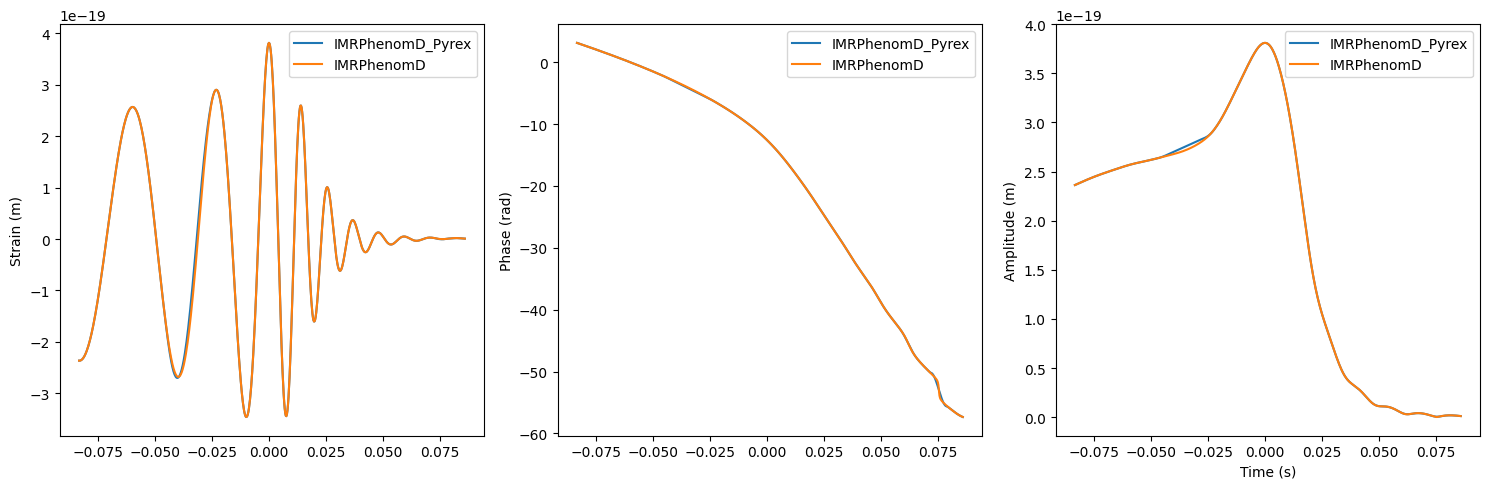

In [2]:
kwargs = {
    "mass1": 100,
    "mass2": 100,
    "inclination": 0,
    "coa_phase": 0,
    "delta_t": 1.0 / 4196,
    "f_lower": 20,
    "f_ref": 25,
    "distance": 10,
}

phen = Waveform.from_model("IMRPhenomD", [(2, 2)], **kwargs)
kwargs.update({"eccentricity": 0,})
phen_ecc = main("IMRPhenomD", [(2, 2)], False, **kwargs)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(phen_ecc.time, phen_ecc[2, 2], label="IMRPhenomD_Pyrex")
axes[0].plot(phen.time, phen[2, 2], label="IMRPhenomD")
axes[0].set_ylabel("Strain (m)")
axes[0].legend()

axes[1].plot(phen_ecc.time, phen_ecc.phase(), label="IMRPhenomD_Pyrex")
axes[1].plot(phen.time, phen.phase(), label="IMRPhenomD")
axes[1].set_ylabel("Phase (rad)")
axes[1].legend()

axes[2].plot(phen_ecc.time, phen_ecc.amp(), label="IMRPhenomD_Pyrex")
axes[2].plot(phen.time, phen.amp(), label="IMRPhenomD")
axes[2].set_ylabel("Amplitude (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.tight_layout()
plt.show()

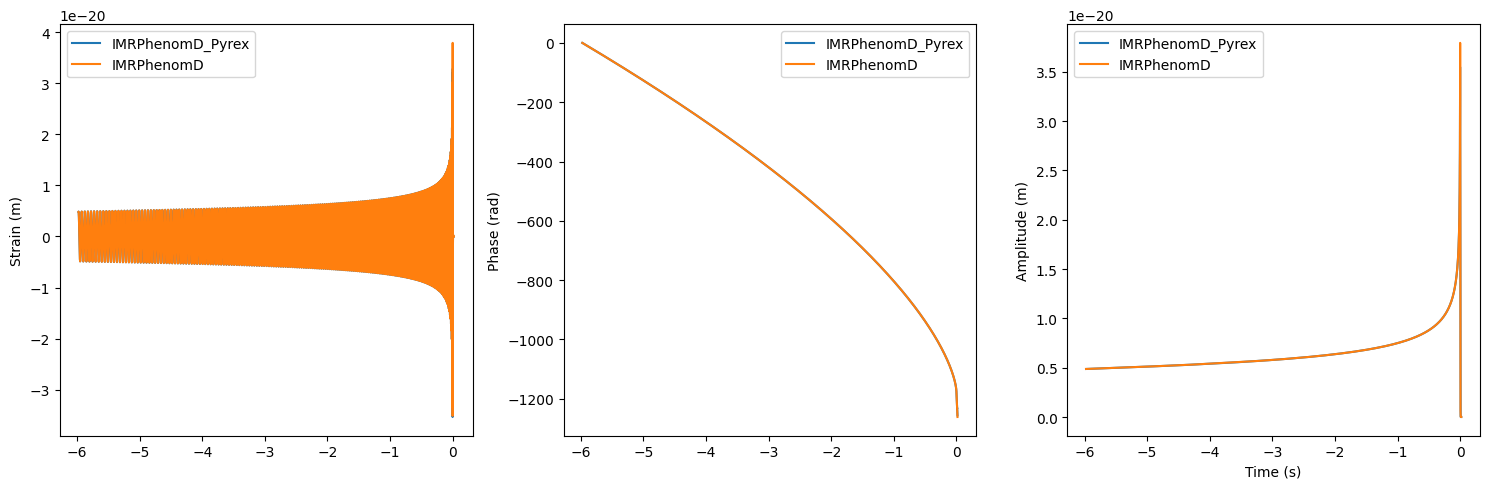

In [7]:
kwargs = {
    "mass1": 10,
    "mass2": 10,
    "inclination": 0,
    "coa_phase": 0,
    "delta_t": 1.0 / 4196,
    "f_lower": 20,
    "f_ref": 25,
    "distance": 10,
}

phen = Waveform.from_model("IMRPhenomD", [(2, 2)], **kwargs)
kwargs.update({"eccentricity": 0,})
phen_ecc = main("IMRPhenomD", [(2, 2)],  False, **kwargs)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(phen_ecc.time, phen_ecc[2, 2], label="IMRPhenomD_Pyrex")
axes[0].plot(phen.time, phen[2, 2], label="IMRPhenomD")
axes[0].set_ylabel("Strain (m)")
axes[0].legend()

axes[1].plot(phen_ecc.time, phen_ecc.phase(), label="IMRPhenomD_Pyrex")
axes[1].plot(phen.time, phen.phase(), label="IMRPhenomD")
axes[1].set_ylabel("Phase (rad)")
axes[1].legend()

axes[2].plot(phen_ecc.time, phen_ecc.amp(), label="IMRPhenomD_Pyrex")
axes[2].plot(phen.time, phen.amp(), label="IMRPhenomD")
axes[2].set_ylabel("Amplitude (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.tight_layout()
plt.show()


In [41]:
def isco_freq(wave:Waveform):
    G = 6.67e-11
    m = 1.9e30
    c = 299792458
    f_max = c**3/(6**(3/2)*np.pi*G*wave.metadata.total_mass*m)
    omegas = wave.omega()
    indices = np.where(omegas < 2 * np.pi * f_max)[0]
    if len(indices) == 0:
        mask = np.array([], dtype=int)
    else:
        breaks = np.where(np.diff(indices) != 1)[0] + 1
        segments = np.split(indices, breaks)

        mask = max(segments, key=len)

    strain = []
    strain.append(wave.amp()[mask] * np.exp(1j * wave.phase()[mask]))

    return Waveform(strain, wave.time[mask], wave.metadata)
    

In [ ]:
spin1=(0,0,0)
spin2=(0,0,0)
distance, inclination, coa_phase = 10, 0, 0
f_lower=20
G = 6.67e-11
m = 1.9e30
c = 299792458

mass_ratio = np.linspace(1, 3, 20)
total_masses = np.linspace(20, 180, 20)

mm_no_ecc_phend  = np.zeros((len(mass_ratio), len(total_masses)))

for i, q in enumerate(mass_ratio):
    for j, M in enumerate(total_masses):
        mass1 = q * M / (q + 1)
        mass2 = M / (q + 1)
        kwargs = {'mass1': mass1, 'mass2': mass2, 'eccentricity': 0.000000000000000000000001,
                  'spin1': spin1, 'spin2': spin2,
                  'inclination': inclination, 'distance': distance,
                  'coa_phase': coa_phase, "delta_t": 1.0 / 4096,
                  "f_ref": 20, "f_lower": f_lower}

        phen_ecc = main("IMRPhenomD", [(2, 2)], False, **kwargs)
        phen_circ = Waveform.from_model("IMRPhenomD", [(2, 2)], **kwargs)

        f_max = c**3/(6**(3/2)*np.pi*G*M*m)
        strain = []
        strain.append(phen_circ[2,2][np.where(phen_circ.time > units.tM_to_tSI(-1500, M))])
        time = phen_circ.time[np.where(phen_circ.time > units.tM_to_tSI(-1500, M))]
        mm_no_ecc_phend[i, j] = 1 - phen_ecc.match(Waveform(strain, time, phen_circ.metadata), f_lower, f_max)

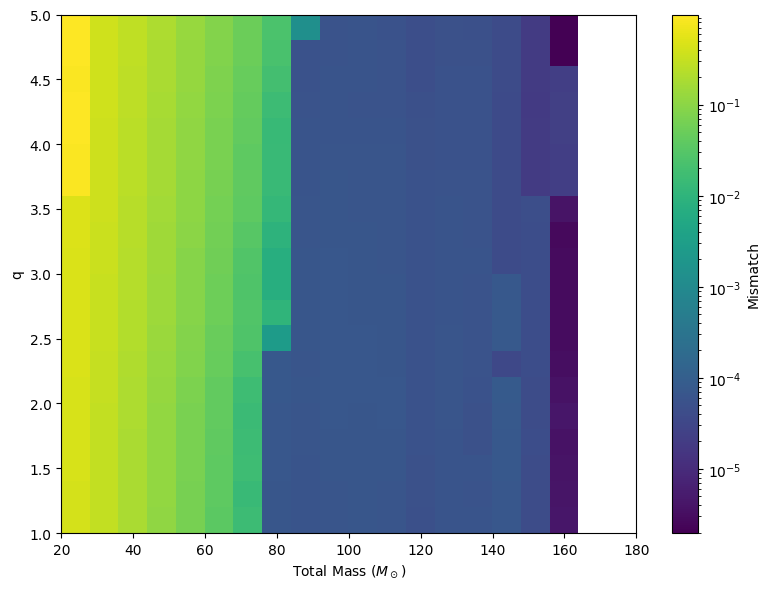

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(mm_no_ecc_phend, origin='lower', aspect='auto',
           extent=[total_masses.min(), total_masses.max(),
                   mass_ratio.min(), mass_ratio.max()],
           cmap='viridis',
           norm=colors.LogNorm(vmin=np.nanmin(mm_no_ecc_phend[mm_no_ecc_phend > 0]),  # avoid log(0)
                               vmax=np.nanmax(mm_no_ecc_phend)))
plt.colorbar(label="Mismatch")
plt.xlabel(r"Total Mass $(M_\odot)$")
plt.ylabel("q")
# plt.title("Mismatch Heatmap: IMRPhenomD Eccentric vs Circular")
plt.tight_layout()
plt.show()

## Inspecting individual waveforms

In order to properly compare these waveforms, they need to be compared to other examples. I will use EccentricTD and TaylorT4 as comparison models; these only compute the inspiral, which is not an issue since Pyrex circularizes the waveform at merger and ringdown anyways.

BIG ISSUE IS THAT ORIGINAL INTERPOLATED AND I DO NOT INTERPOLATE THE ORIGINAL WAVEFORM, THIS CAUSES INFS AND NANS BUT IF HANDLED CORRECTLY IT KIND OF WORKS WITH OTHER DRAWBACKS.

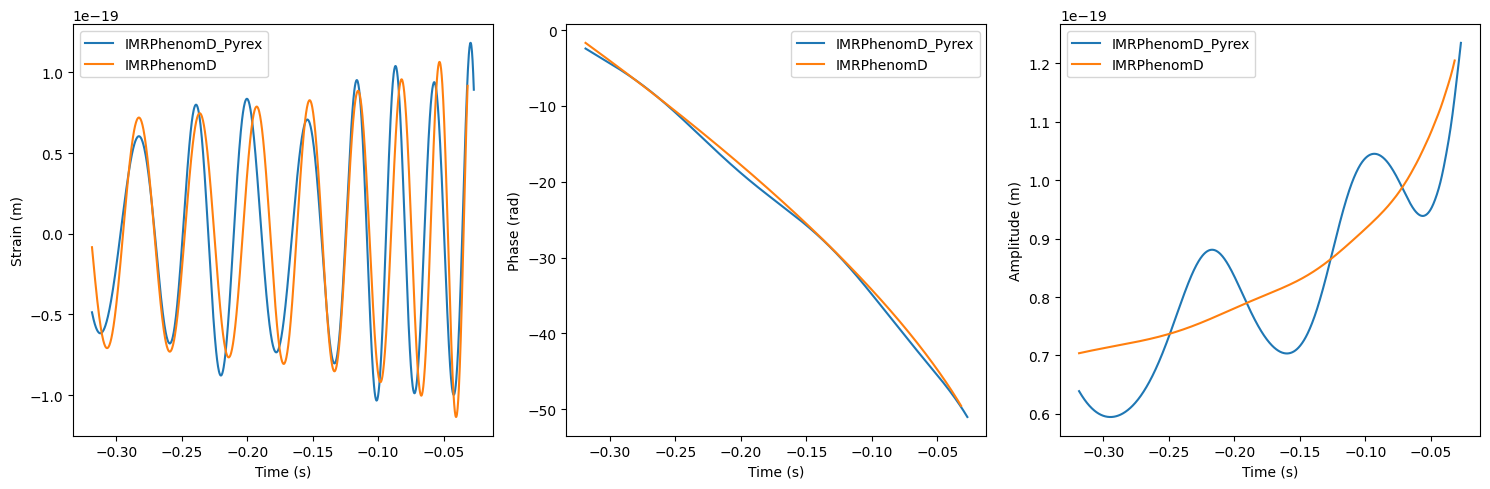

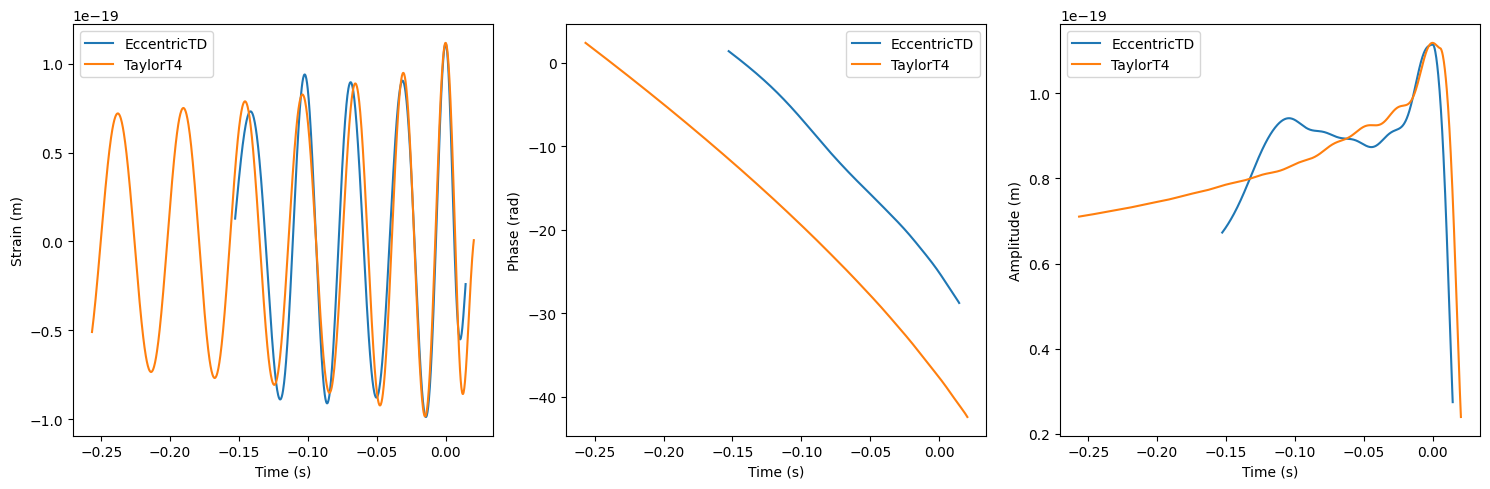

In [56]:
kwargs = {
    "mass1": 50,
    "mass2": 50,
    "inclination": 0,
    "coa_phase": 0,
    "delta_t": 1.0 / 4196,
    "f_lower": 20,
    "f_ref": 25,
    "distance": 10,
}

phen = isco_freq(Waveform.from_model("IMRPhenomD", [(2, 2)], **kwargs))
kwargs.update({"amplitude0": 0, "phase0": 4})
taylor_t4 = isco_freq(Waveform.from_model("TaylorT4", [(2, 2)], **kwargs))
kwargs.update({"eccentricity": 0.1})
phen_ecc = isco_freq(main("IMRPhenomD", [(2, 2)], **kwargs))
eccentric_td = isco_freq(Waveform.from_model("EccentricTD", [(2, 2)], **kwargs))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(phen_ecc.time, phen_ecc[2, 2], label="IMRPhenomD_Pyrex")
axes[0].plot(phen.time, phen[2, 2], label="IMRPhenomD")
axes[0].set_ylabel("Strain (m)")
axes[0].set_xlabel("Time (s)")
axes[0].legend()

axes[1].plot(phen_ecc.time, phen_ecc.phase(), label="IMRPhenomD_Pyrex")
axes[1].plot(phen.time, phen.phase(), label="IMRPhenomD")
axes[1].set_ylabel("Phase (rad)")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

axes[2].plot(phen_ecc.time, phen_ecc.amp(), label="IMRPhenomD_Pyrex")
axes[2].plot(phen.time, phen.amp(), label="IMRPhenomD")
axes[2].set_ylabel("Amplitude (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(eccentric_td.time, eccentric_td[2, 2], label="EccentricTD")
axes[0].plot(taylor_t4.time, taylor_t4[2, 2], label="TaylorT4")
axes[0].set_ylabel("Strain (m)")
axes[0].set_xlabel("Time (s)")
axes[0].legend()

axes[1].plot(eccentric_td.time, eccentric_td.phase(), label="EccentricTD")
axes[1].plot(taylor_t4.time, taylor_t4.phase(), label="TaylorT4")
axes[1].set_ylabel("Phase (rad)")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

axes[2].plot(eccentric_td.time, eccentric_td.amp(), label="EccentricTD")
axes[2].plot(taylor_t4.time, taylor_t4.amp(), label="TaylorT4")
axes[2].set_ylabel("Amplitude (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.tight_layout()
plt.show()


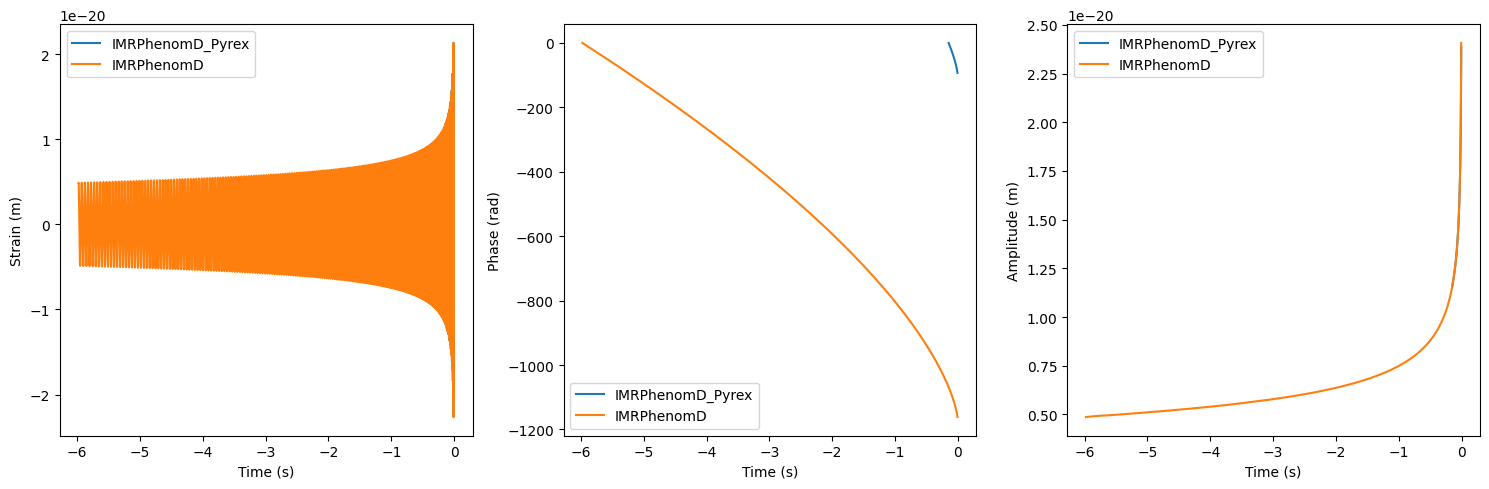

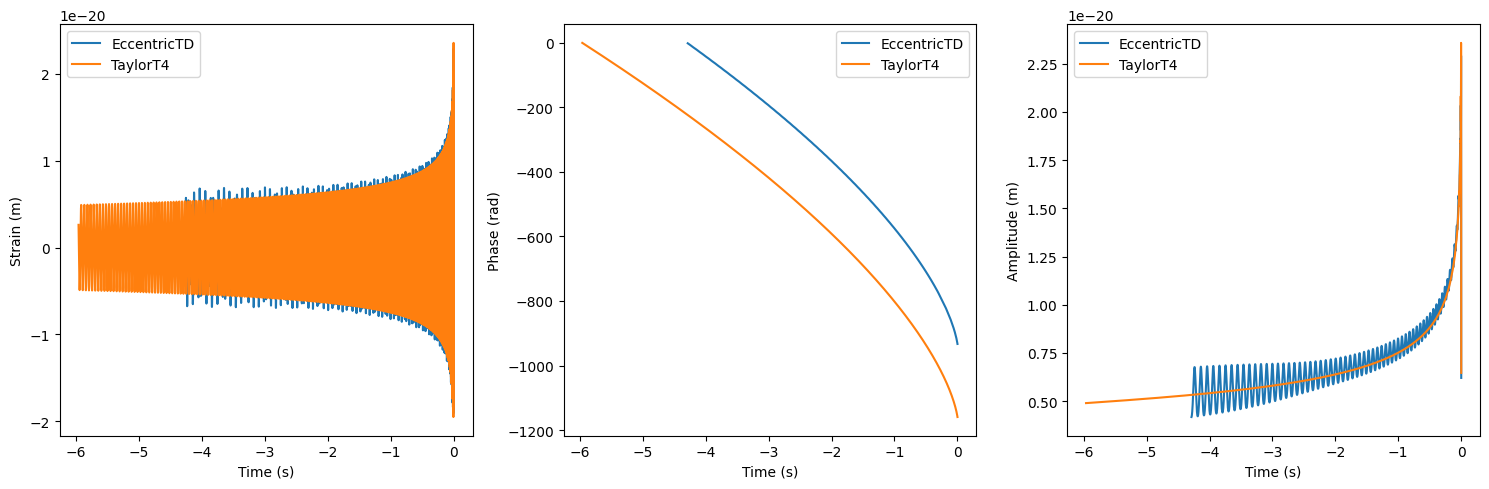

In [57]:
kwargs = {
    "mass1": 10,
    "mass2": 10,
    "inclination": 0,
    "coa_phase": 0,
    "delta_t": 1.0 / 4196,
    "f_lower": 20,
    "f_ref": 25,
    "distance": 10,
}

phen = isco_freq(Waveform.from_model("IMRPhenomD", [(2, 2)], **kwargs))
kwargs.update({"amplitude0": 0, "phase0": 4})
taylor_t4 = isco_freq(Waveform.from_model("TaylorT4", [(2, 2)], **kwargs))
kwargs.update({"eccentricity": 0.1})
phen_ecc = isco_freq(main("IMRPhenomD", [(2, 2)], **kwargs))
eccentric_td = isco_freq(Waveform.from_model("EccentricTD", [(2, 2)], **kwargs))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(phen_ecc.time, phen_ecc[2, 2], label="IMRPhenomD_Pyrex")
axes[0].plot(phen.time, phen[2, 2], label="IMRPhenomD")
axes[0].set_ylabel("Strain (m)")
axes[0].set_xlabel("Time (s)")
axes[0].legend()

axes[1].plot(phen_ecc.time, phen_ecc.phase(), label="IMRPhenomD_Pyrex")
axes[1].plot(phen.time, phen.phase(), label="IMRPhenomD")
axes[1].set_ylabel("Phase (rad)")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

axes[2].plot(phen_ecc.time, phen_ecc.amp(), label="IMRPhenomD_Pyrex")
axes[2].plot(phen.time, phen.amp(), label="IMRPhenomD")
axes[2].set_ylabel("Amplitude (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(eccentric_td.time, eccentric_td[2, 2], label="EccentricTD")
axes[0].plot(taylor_t4.time, taylor_t4[2, 2], label="TaylorT4")
axes[0].set_ylabel("Strain (m)")
axes[0].set_xlabel("Time (s)")
axes[0].legend()

axes[1].plot(eccentric_td.time, eccentric_td.phase(), label="EccentricTD")
axes[1].plot(taylor_t4.time, taylor_t4.phase(), label="TaylorT4")
axes[1].set_ylabel("Phase (rad)")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

axes[2].plot(eccentric_td.time, eccentric_td.amp(), label="EccentricTD")
axes[2].plot(taylor_t4.time, taylor_t4.amp(), label="TaylorT4")
axes[2].set_ylabel("Amplitude (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.tight_layout()
plt.show()


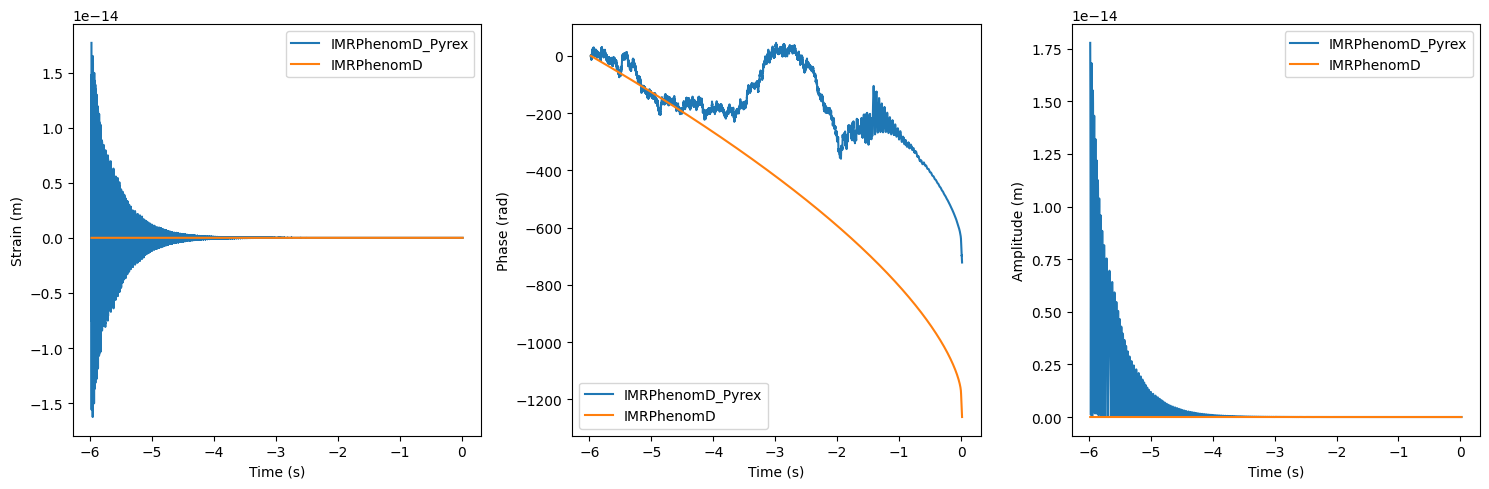

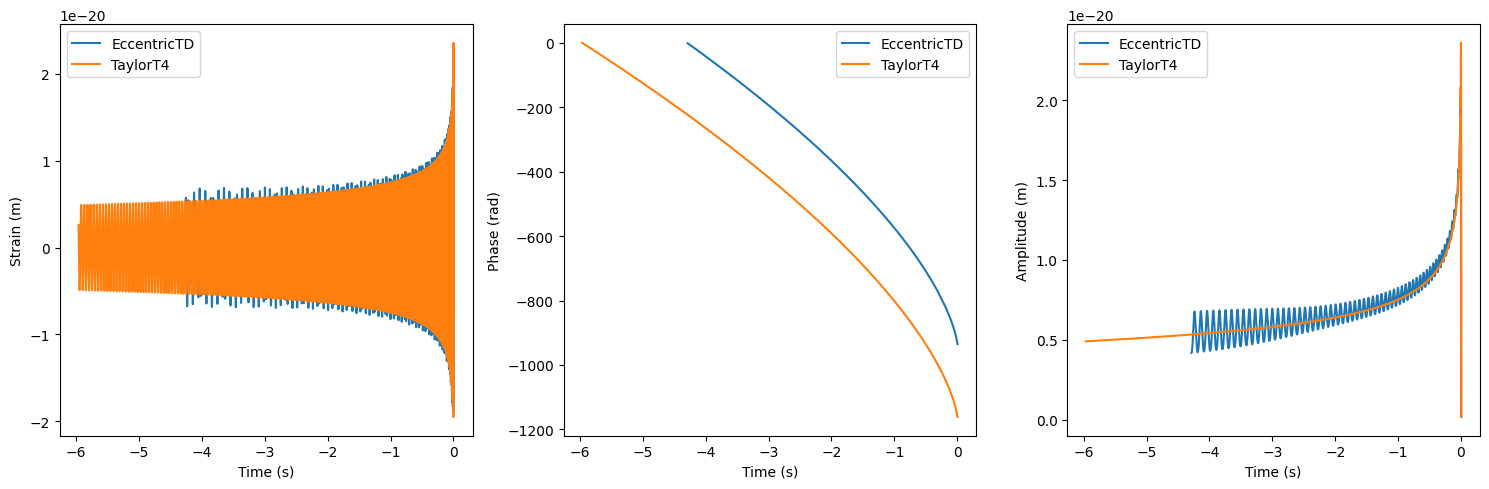

In [8]:
kwargs = {
    "mass1": 10,
    "mass2": 10,
    "inclination": 0,
    "coa_phase": 0,
    "delta_t": 1.0 / 4196,
    "f_lower": 20,
    "f_ref": 25,
    "distance": 10,
}

phen = Waveform.from_model("IMRPhenomD", [(2, 2)], **kwargs)
kwargs.update({"amplitude0": 0, "phase0": 4})
taylor_t4 = Waveform.from_model("TaylorT4", [(2, 2)], **kwargs)
kwargs.update({"eccentricity": 0.1})
phen_ecc = main("IMRPhenomD", [(2, 2)], False, **kwargs)
eccentric_td = Waveform.from_model("EccentricTD", [(2, 2)], **kwargs)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(phen_ecc.time, phen_ecc[2, 2], label="IMRPhenomD_Pyrex")
axes[0].plot(phen.time, phen[2, 2], label="IMRPhenomD")
axes[0].set_ylabel("Strain (m)")
axes[0].set_xlabel("Time (s)")
axes[0].legend()

axes[1].plot(phen_ecc.time, phen_ecc.phase(), label="IMRPhenomD_Pyrex")
axes[1].plot(phen.time, phen.phase(), label="IMRPhenomD")
axes[1].set_ylabel("Phase (rad)")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

axes[2].plot(phen_ecc.time, phen_ecc.amp(), label="IMRPhenomD_Pyrex")
axes[2].plot(phen.time, phen.amp(), label="IMRPhenomD")
axes[2].set_ylabel("Amplitude (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(eccentric_td.time, eccentric_td[2, 2], label="EccentricTD")
axes[0].plot(taylor_t4.time, taylor_t4[2, 2], label="TaylorT4")
axes[0].set_ylabel("Strain (m)")
axes[0].set_xlabel("Time (s)")
axes[0].legend()

axes[1].plot(eccentric_td.time, eccentric_td.phase(), label="EccentricTD")
axes[1].plot(taylor_t4.time, taylor_t4.phase(), label="TaylorT4")
axes[1].set_ylabel("Phase (rad)")
axes[1].set_xlabel("Time (s)")
axes[1].legend()

axes[2].plot(eccentric_td.time, eccentric_td.amp(), label="EccentricTD")
axes[2].plot(taylor_t4.time, taylor_t4.amp(), label="TaylorT4")
axes[2].set_ylabel("Amplitude (m)")
axes[2].set_xlabel("Time (s)")
axes[2].legend()

plt.tight_layout()
plt.show()

## Mismatch heatmaps

In [14]:
q = 1
spin1=(0,0,0)
spin2=(0,0,0)
distance, inclination, coa_phase = 10, 0, 0
f_lower=20

eccentricities = np.linspace(0, 0.2, 20)
total_masses = np.linspace(20, 200, 20)

mismatches = np.zeros((len(eccentricities), len(total_masses)))

for i, e in enumerate(eccentricities):
    for j, M in enumerate(total_masses):
        mass1 = q * M / (q + 1)
        mass2 = M / (q + 1)
        kwargs = {'mass1': mass1, 'mass2': mass2, 'eccentricity': e,
                  'spin1': spin1, 'spin2': spin2,
                  'inclination': inclination, 'distance': distance,
                  'coa_phase': coa_phase, "delta_t": 1.0 / 4096,
                  "f_ref": 20, "f_lower": f_lower}

        phen_ecc = main("IMRPhenomD", [(2, 2)], **kwargs)
        kwargs.pop("eccentricity")
        phen_circ = Waveform.from_model("IMRPhenomD", [(2, 2)], **kwargs)

        mismatches[i, j] = 1 - phen_ecc.match(phen_circ, f_lower)

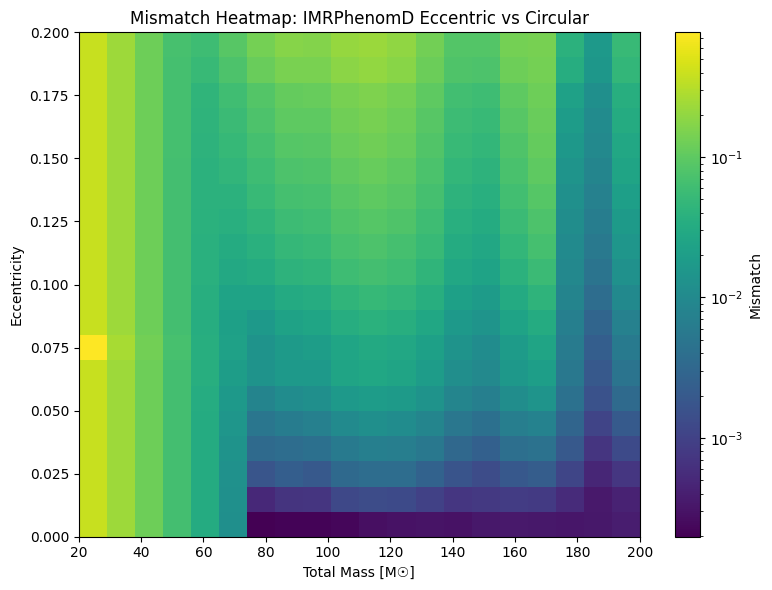

In [15]:
plt.figure(figsize=(8, 6))
plt.imshow(mismatches, origin='lower', aspect='auto',
           extent=[total_masses.min(), total_masses.max(),
                   eccentricities.min(), eccentricities.max()],
           cmap='viridis',
           norm=colors.LogNorm(vmin=np.nanmin(mismatches[mismatches > 0]),  # avoid log(0)
                               vmax=np.nanmax(mismatches)))
plt.colorbar(label="Mismatch")
plt.xlabel("Total Mass [M☉]")
plt.ylabel("Eccentricity")
plt.title("Mismatch Heatmap: IMRPhenomD Eccentric vs Circular")
plt.tight_layout()
plt.show()

In [23]:
q = 1
spin1=(0,0,0)
spin2=(0,0,0)
distance, inclination, coa_phase = 10, 0, 0
f_lower=20

eccentricities = np.linspace(1e-8, 0.2, 20)
total_masses = np.linspace(20, 200, 20)

mismatches = np.zeros((len(eccentricities), len(total_masses)))

for i, e in enumerate(eccentricities):
    for j, M in enumerate(total_masses):
        mass1 = q * M / (q + 1)
        mass2 = M / (q + 1)
        kwargs = {'mass1': mass1, 'mass2': mass2, 'eccentricity': 0,
                  'spin1': spin1, 'spin2': spin2,
                  'inclination': inclination, 'distance': distance,
                  'coa_phase': coa_phase, "delta_t": 1.0 / 4096,
                  "f_ref": 20, "f_lower": f_lower}
        
        kwargs.update({"amplitude0": 0, "phase0": 4})

        taylor_t4 = Waveform.from_model("TaylorT4", [(2, 2)], **kwargs)
        kwargs.update({"eccentricity": e})
        eccentric_td = Waveform.from_model("EccentricTD", [(2, 2)], **kwargs)

        mismatches[i, j] = 1 - taylor_t4.match(eccentric_td, f_lower)

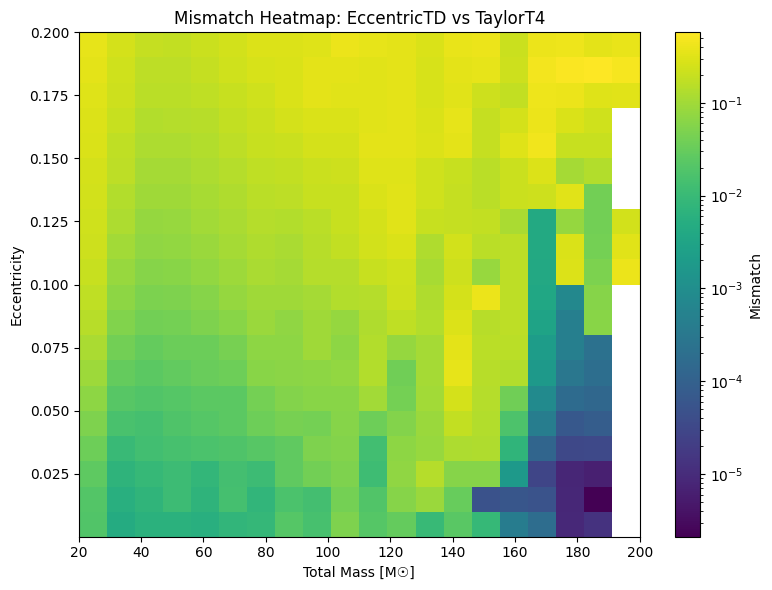

In [22]:
plt.figure(figsize=(8, 6))
plt.imshow(mismatches, origin='lower', aspect='auto',
           extent=[total_masses.min(), total_masses.max(),
                   eccentricities.min(), eccentricities.max()],
           cmap='viridis',
           norm=colors.LogNorm(vmin=np.nanmin(mismatches[mismatches > 0]),  # avoid log(0)
                               vmax=np.nanmax(mismatches)))
plt.colorbar(label="Mismatch")
plt.xlabel("Total Mass [M☉]")
plt.ylabel("Eccentricity")
plt.title("Mismatch Heatmap: EccentricTD vs TaylorT4")
plt.tight_layout()
plt.show()

It seems that the Pyrex waveform underestimates the size of the amplitude modulations present under identical conditions in EccentricTD.

### Setting expectations

In [7]:
# Match self first here as a test

### Setting expectations

## Conclusions